In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import os

In [2]:
image_dataset_path = '/content/drive/MyDrive/codetice/input/Flicker8k_Dataset'
caption_dataset_path = '/content/drive/MyDrive/codetice/input/Flickr8k_text/Flickr8k.token.txt'

In [3]:
# load the caption file & read it
def load_caption_file(path):

    # dictionary to store captions
    captions_dict = {}

    # iterate through the file
    for caption in open(path):

        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)

        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text

    return captions_dict

# call the function
captions_dict = load_caption_file(caption_dataset_path)

In [4]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [5]:
# delete unwanted
del captions_dict

In [6]:
print('"' + list(new_captions_dict.keys())[0] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[0]])

"1000268201_693b08cb0e" : startseq child in pink dress is climbing up set of stairs in an entry way endseq


In [7]:
len(new_captions_dict)

8092

In [8]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index ]

In [9]:
caption_images_list[0]

'3726730085_2468ee9220'

In [10]:
len(caption_images_list)

8091

In [11]:
train_validate_images = caption_images_list[0:8081]

In [12]:
test_images = caption_images_list[8081:8091]
test_images

['111766423_4522d36e56',
 '112243673_fd68255217',
 '1131804997_177c3c0640',
 '1094462889_f9966dafa6',
 '1141739219_2c47195e4c',
 '109823397_e35154645f',
 '109260216_85b0be5378',
 '1107246521_d16a476380',
 '111537217_082a4ba060',
 '109738916_236dc456ac']

In [13]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()

    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # summarize
    print(model.summary())

    # extract features from each photo
    features = dict()

    for name in image_keys:

        # load an image from file
        filename = directory + '/' + name + '.jpg'

        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))

        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the VGG model
        image = preprocess_input(image)

        # get features
        feature = model.predict(image, verbose=0)

        # get image id
        image_id = name.split('.')[0]

        # store feature
        features[image_id] = feature

#         print('>%s' % name)


    return features

In [14]:
# extracting image features for train_validate_images
train_validate_features = extract_features(image_dataset_path, train_validate_images)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

3726730085_2468ee9220 : [[0.         0.94499123 0.89725214 ... 0.         0.33003217 0.02918297]]


In [19]:
type(train_validate_features)

dict

In [20]:
len(train_validate_features)

8081

In [29]:
from pickle import dump
dump(train_validate_features, open('./train_validate_features.pkl', 'wb'))

In [19]:
import pickle
with open('./train_validate_features.pkl', 'rb') as f:
    train_validate_features = pickle.load(f)

In [14]:
# load libraries
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [20]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():

    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):

         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8081

In [22]:
list(train_validate_image_caption.values())[1]

'startseq black dog and spotted dog are fighting endseq'

In [23]:
# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

def prepare_data(image_keys):

    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images
    for image in image_keys:

        # store the caption of that image
        caption = train_validate_image_caption[image]

        # split the image into tokens
        caption = caption.split()

        # generate integer sequences of the
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # encode the output sequence
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image][0] )

            x2.append(x2_seq)

            y.append(y_seq)

    return np.array(x1), np.array(x2), np.array(y)

In [24]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [25]:
# feature extractor model
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256)(droplayer_)

# decoder model
decoder1 = add([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 256)              1147648   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_1[0][0]']             
                                                                                              

In [26]:
# define checkpoint callback
filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

callbacks = [
             ModelCheckpoint(filepath= filepath, save_best_only=True, monitor='val_loss') ]

In [29]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (72279, 4096)
shape of train_x2  (72279, 30)
shape of train_y  (72279, 4483)

shape of validate_x1  (10258, 4096)
shape of validate_x2  (10258, 30)
shape of validate_y  (10258, 4483)


In [27]:
# fit model
history = model.fit([train_x1, train_x2],
                    train_y,
                    verbose = 1,
                    epochs = 20,
                    callbacks = callbacks,
                    validation_data=([validate_x1, validate_x2], validate_y))

Epoch 1/20
2259/2259 [==============================] - 279s 117ms/step - loss: 5.0524 - val_loss: 4.5224
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2259/2259 [==============================] - 249s 110ms/step - loss: 4.1949 - val_loss: 4.3382
Epoch 3/20
2259/2259 [==============================] - 244s 108ms/step - loss: 3.8604 - val_loss: 4.3079
Epoch 4/20
2259/2259 [==============================] - 246s 109ms/step - loss: 3.6366 - val_loss: 4.3395
Epoch 5/20
2259/2259 [==============================] - 240s 106ms/step - loss: 3.4631 - val_loss: 4.4250
Epoch 6/20
2259/2259 [==============================] - 242s 107ms/step - loss: 3.3213 - val_loss: 4.5103
Epoch 7/20
2259/2259 [==============================] - 247s 109ms/step - loss: 3.2009 - val_loss: 4.6049
Epoch 8/20
2259/2259 [==============================] - 249s 110ms/step - loss: 3.0936 - val_loss: 4.7788
Epoch 9/20
2259/2259 [==============================] - 236s 104ms/step - loss: 3.0060 - val_loss: 4.8280
Epoch 10/20
2259/2259 [==============================] - 236s 105ms/step - loss: 2.9198 - val_loss: 4.9520
Epoch 11/20
2259/2259 [==============================] -

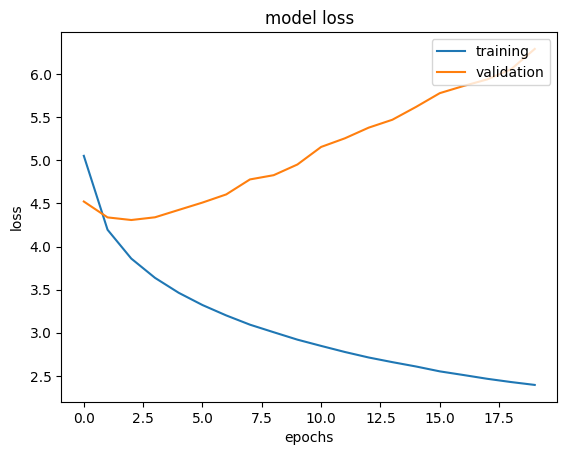

In [32]:
# plot training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [28]:
# saving the model with last parameter
model.save('./latest_model.h5')

In [30]:
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [35]:
from keras.models import load_model
# load the model
modl = load_model('./latest_model.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count]))

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq man in red shirt and jeans is standing in the sand endseq

Actual caption ->  startseq baby is lifted into the air by man wearing no shirt endseq
*********************************************************************

Predicted caption ->  startseq brown and white dog is running in the snow endseq

Actual caption ->  startseq black and white dog is running through the sand on beach endseq
*********************************************************************

Predicted caption ->  startseq man in red shirt and sunglasses walks down city street endseq

Actual caption ->  startseq large man at party with drink in his right hand endseq
*********************************************************************

Predicted caption ->  startseq boy in red shirt is standing in the sand endseq

Actual caption ->  startseq boy in blue shirt is walking along tan and blue wall endseq
*********************************************************************

Predicted caption ->

In [36]:
!pip install astropy>=3.1
!pip install sunpy
!pip install streamlit==1.24.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 37.5 MB/s eta 0:00:00


In [93]:
%%writefile app3.py
import streamlit as st
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
import os

st.title("IMAGE CAPTIONING")
st.text("The following AI will help you write captions to images")
image_dataset_path = '/content/drive/MyDrive/codetice/input/Flicker8k_Dataset'
caption_dataset_path = '/content/drive/MyDrive/codetice/input/Flickr8k_text/Flickr8k.token.txt'

# load the caption file & read it
def load_caption_file(path):

    # dictionary to store captions
    captions_dict = {}

    # iterate through the file
    for caption in open(path):

        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)

        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text

    return captions_dict

# call the function
captions_dict = load_caption_file(caption_dataset_path)

# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

del captions_dict

caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index ]

train_validate_images = caption_images_list[0:8081]

def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text



def load_image(image_file):
	img = Image.open(image_file)
	return img

uploaded_files = st.file_uploader("Choose a jpg file",type='jpg', accept_multiple_files=True)
for uploaded_file in uploaded_files:
    bytes_data = uploaded_file.read()
    img = load_image( uploaded_file)
    with open(uploaded_file.name,'wb') as f:
       f.write(uploaded_file.getbuffer())
    # load the model
    modl = load_model('./latest_model.h5')
    # generate description
    tokenizr = Tokenizer()
    tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
    max_length = 30
    photo = extract_feat('/content/{}'.format(uploaded_file.name))
    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    description=description.replace('startseq', '')
    description=description.replace('endseq', '')
    st.image(img,width=250,caption=description)


Overwriting app3.py


In [95]:
!streamlit run app3.py & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.170.52.125
[##................] - fetchMetadata: sill resolveWithNewModule ms@2.1.2 checki


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.170.52.125:8501

npx: installed 22 in 3.207s
your url is: https://soft-bobcats-yell.loca.lt
2023-11-17 13:32:08.470739: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 13:32:08.471701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 13:32:08.472051: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 13:32:10.906743: W tensorflow/compiler/tf2